U-net
======

https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [1]:
# install pytorch (http://pytorch.org/) if run from Google Colaboratory
import sys
if 'google.colab' in sys.modules and 'torch' not in sys.modules:
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

    !pip3 install https://download.pytorch.org/whl/{accelerator}/torch-1.1.0-{platform}-linux_x86_64.whl
    !pip3 install https://download.pytorch.org/whl/{accelerator}/torchvision-0.3.0-{platform}-linux_x86_64.whl

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from matplotlib import pyplot as plt

Parameter Settings
-------------------


In [15]:
# 2-d latent space, parameter count in same order of magnitude
# as in the original VAE paper (VAE paper has about 3x as many)
latent_dims = 100
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True
image_size = 256

# # 10-d latent space, for comparison with non-variational auto-encoder
# latent_dims = 10
# num_epochs = 100
# batch_size = 128
# capacity = 64
# learning_rate = 1e-3
# variational_beta = 1
# use_gpu = True

MNIST Data Loading
-------------------

MNIST images show digits from 0-9 in 28x28 grayscale images. We do not center them at 0, because we will be using a binary cross-entropy loss that treats pixel values as probabilities in [0,1]. We create both a training set and a test set.

In [16]:
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageOps

#from torchvision.datasets import FashionMNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

class CustomDataSet(Dataset):
    def __init__(self, input_dir=f'./five_cropped_input{image_size}',
                       output_dir=f'./five_cropped_output{image_size}', black_and_white=False, transform=None):
        self.input_dir = input_dir
        self.output_dir = output_dir
        if black_and_white:
            self.input_dir += '(bw)'
            self.output_dir += '(bw)'
        self.transform = transform
        self.total_imgs = os.listdir(self.input_dir)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc_in = os.path.join(self.input_dir, self.total_imgs[idx])
        img_loc_out = os.path.join(self.output_dir, self.total_imgs[idx])
        fig_in = ImageOps.invert(Image.open(img_loc_in))
        fig_out = ImageOps.invert(Image.open(img_loc_out))
        tensor_image_in = self.transform(fig_in)
        tensor_image_out = self.transform(fig_out)
        return tensor_image_in, tensor_image_out

full_dataset = CustomDataSet(input_dir=f'./five_cropped_input{image_size}',
                             output_dir=f'./five_cropped_output{image_size}', black_and_white=False, transform=img_transform)

train_size = 15000
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

#train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [17]:
len(train_dataset), len(test_dataset), len(train_dataloader), len(test_dataloader)

(15000, 7030, 118, 55)

In [18]:
train_dataset[0][0].shape

torch.Size([1, 256, 256])

In [19]:
for batch, _ in train_dataloader:
    print(batch.shape)
    break

torch.Size([128, 1, 256, 256])


U-net
-----------------------
We use a convolutional encoder and decoder, which generally gives better performance than fully connected versions that have the same number of parameters.

In convolution layers, we increase the channels as we approach the bottleneck, but note that the total number of features still decreases, since the channels increase by a factor of 2 in each convolution, but the spatial size decreases by a factor of 4.

Kernel size 4 is used to avoid biasing problems described here: https://distill.pub/2016/deconv-checkerboard/

In [20]:
import functools

class UnetSkipConnectionBlock(nn.Module):
    """Defines the Unet submodule with skip connection.
        X -------------------identity----------------------
        |-- downsampling -- |submodule| -- upsampling --|
    """

    def __init__(self, outer_nc, inner_nc, input_nc=None,
                 submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet submodule with skip connections.
        Parameters:
            outer_nc (int) -- the number of filters in the outer conv layer
            inner_nc (int) -- the number of filters in the inner conv layer
            input_nc (int) -- the number of channels in input images/features
            submodule (UnetSkipConnectionBlock) -- previously defined submodules
            outermost (bool)    -- if this module is the outermost module
            innermost (bool)    -- if this module is the innermost module
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
        """
        super(UnetSkipConnectionBlock, self).__init__()
        self.outermost = outermost
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        if input_nc is None:
            input_nc = outer_nc
        downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
                             stride=2, padding=1, bias=use_bias)
        downrelu = nn.LeakyReLU(0.2, True)
        downnorm = norm_layer(inner_nc)
        uprelu = nn.ReLU(True)
        upnorm = norm_layer(outer_nc)

        if outermost:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1)
            down = [downconv]
            up = [uprelu, upconv, nn.Sigmoid()]
            model = down + [submodule] + up
        elif innermost:
            upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv]
            up = [uprelu, upconv, upnorm]
            model = down + up
        else:
            upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
                                        kernel_size=4, stride=2,
                                        padding=1, bias=use_bias)
            down = [downrelu, downconv, downnorm]
            up = [uprelu, upconv, upnorm]

            if use_dropout:
                model = down + [submodule] + up + [nn.Dropout(0.5)]
            else:
                model = down + [submodule] + up

        self.model = nn.Sequential(*model)

    def forward(self, x):
        if self.outermost:
            return self.model(x)
        else:   # add skip connections
            return torch.cat([x, self.model(x)], 1)
    
class UnetGenerator(nn.Module):
    """Create a Unet-based generator"""

    def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
        """Construct a Unet generator
        Parameters:
            input_nc (int)  -- the number of channels in input images
            output_nc (int) -- the number of channels in output images
            num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
                                image of size 128x128 will become of size 1x1 # at the bottleneck
            ngf (int)       -- the number of filters in the last conv layer
            norm_layer      -- normalization layer
        We construct the U-Net from the innermost layer to the outermost layer.
        It is a recursive process.
        """
        super(UnetGenerator, self).__init__()
        # construct unet structure
        unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
        for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
            unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
        # gradually reduce the number of filters from ngf * 8 to ngf
        unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
        self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

    def forward(self, input):
        """Standard forward"""
        return self.model(input)

unet = UnetGenerator(input_nc=1, output_nc=1, num_downs=5, ngf=16)

device = 'cpu'#torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
unet = unet.to(device)

num_params = sum(p.numel() for p in unet.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params, ', device: ', device)

Number of parameters: 1042081 , device:  cpu


Train U-net
--------

Training ...
Epoch [1 / 100] time: 648.00 (sec) average reconstruction error: 1625902.162540
Validation error: 649003.368182


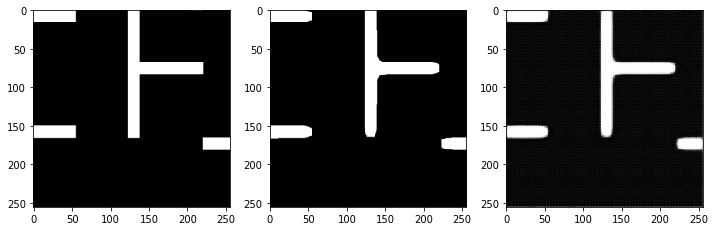

Epoch [2 / 100] time: 624.52 (sec) average reconstruction error: 477027.918167
Epoch [3 / 100] time: 626.26 (sec) average reconstruction error: 356525.847193
Epoch [4 / 100] time: 626.42 (sec) average reconstruction error: 321936.013672
Epoch [5 / 100] time: 625.01 (sec) average reconstruction error: 309671.706700
Epoch [6 / 100] time: 627.01 (sec) average reconstruction error: 299149.110501
Validation error: 304797.036364


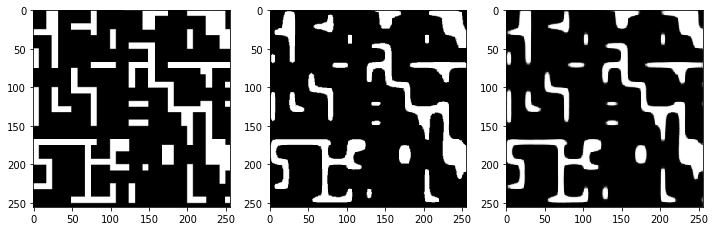

Epoch [7 / 100] time: 638.66 (sec) average reconstruction error: 292529.689155
Epoch [8 / 100] time: 625.28 (sec) average reconstruction error: 289095.234309
Epoch [9 / 100] time: 626.35 (sec) average reconstruction error: 285219.171147
Epoch [10 / 100] time: 626.54 (sec) average reconstruction error: 283209.376920
Epoch [11 / 100] time: 628.70 (sec) average reconstruction error: 278844.802105
Validation error: 278268.505682


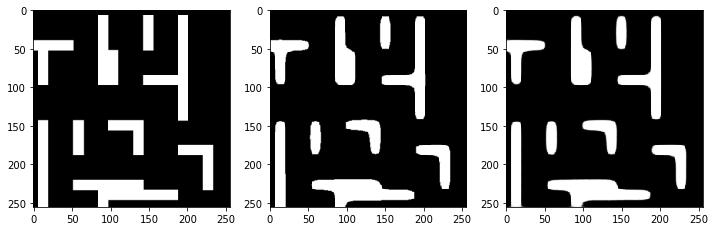

Epoch [12 / 100] time: 627.90 (sec) average reconstruction error: 279754.969147
Epoch [13 / 100] time: 627.13 (sec) average reconstruction error: 276729.203787
Epoch [14 / 100] time: 626.99 (sec) average reconstruction error: 271348.711401
Epoch [15 / 100] time: 602.67 (sec) average reconstruction error: 270731.190877
Epoch [16 / 100] time: 547.67 (sec) average reconstruction error: 271525.732124
Validation error: 273389.875000


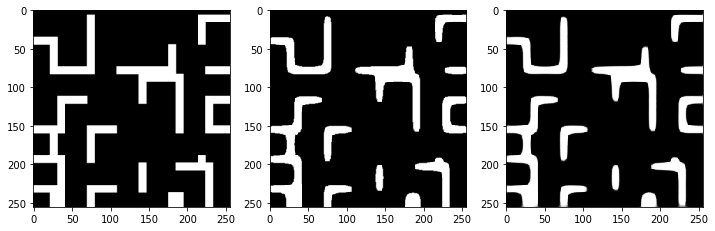

Epoch [17 / 100] time: 546.08 (sec) average reconstruction error: 268717.662308
Epoch [18 / 100] time: 546.12 (sec) average reconstruction error: 269189.544624
Epoch [19 / 100] time: 550.42 (sec) average reconstruction error: 268095.269002
Epoch [20 / 100] time: 546.16 (sec) average reconstruction error: 264894.635891
Epoch [21 / 100] time: 550.29 (sec) average reconstruction error: 263741.358316
Validation error: 270648.099716


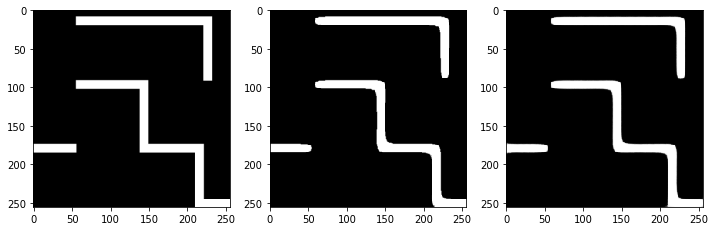

Epoch [22 / 100] time: 560.97 (sec) average reconstruction error: 265097.139665
Epoch [23 / 100] time: 550.23 (sec) average reconstruction error: 263725.159958
Epoch [24 / 100] time: 552.14 (sec) average reconstruction error: 264556.218916
Epoch [25 / 100] time: 550.35 (sec) average reconstruction error: 263299.484772
Epoch [26 / 100] time: 550.98 (sec) average reconstruction error: 260103.716035
Validation error: 273612.331250


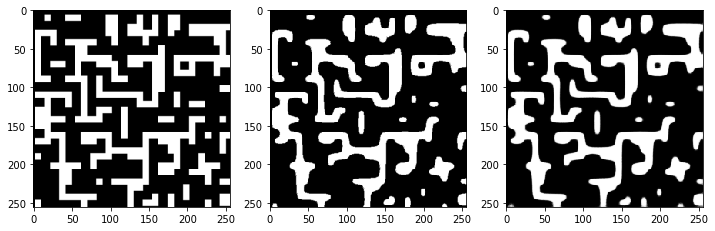

Epoch [27 / 100] time: 550.65 (sec) average reconstruction error: 258812.177569
Epoch [28 / 100] time: 551.80 (sec) average reconstruction error: 256619.897577
Epoch [29 / 100] time: 555.60 (sec) average reconstruction error: 257738.259997
Epoch [30 / 100] time: 550.02 (sec) average reconstruction error: 256544.832958
Epoch [31 / 100] time: 529.39 (sec) average reconstruction error: 254658.709415
Validation error: 271200.030966


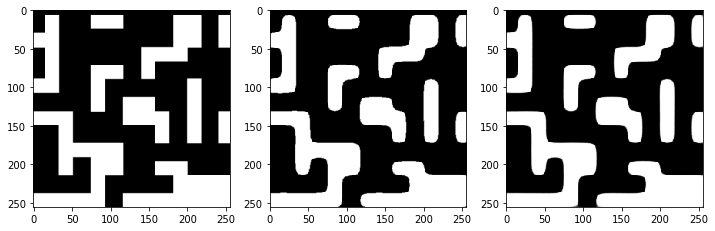

Epoch [32 / 100] time: 530.60 (sec) average reconstruction error: 257477.551841
Epoch [33 / 100] time: 531.00 (sec) average reconstruction error: 255506.465241
Epoch [34 / 100] time: 530.55 (sec) average reconstruction error: 253548.370266
Epoch [35 / 100] time: 530.43 (sec) average reconstruction error: 255002.681343
Epoch [36 / 100] time: 532.69 (sec) average reconstruction error: 252150.161083
Validation error: 271461.651705


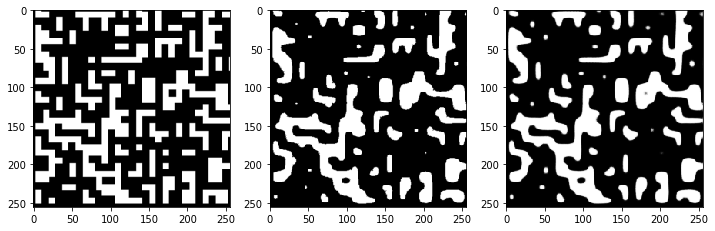

Epoch [37 / 100] time: 546.86 (sec) average reconstruction error: 251996.967823
Epoch [38 / 100] time: 533.10 (sec) average reconstruction error: 251895.028171
Epoch [39 / 100] time: 528.68 (sec) average reconstruction error: 250697.042373
Epoch [40 / 100] time: 526.33 (sec) average reconstruction error: 249978.325113
Epoch [41 / 100] time: 564.49 (sec) average reconstruction error: 250225.333653
Validation error: 270340.397443


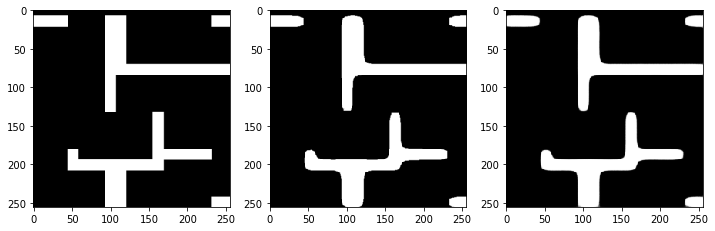

Epoch [42 / 100] time: 528.99 (sec) average reconstruction error: 249591.816307
Epoch [43 / 100] time: 525.33 (sec) average reconstruction error: 252274.092095
Epoch [44 / 100] time: 528.68 (sec) average reconstruction error: 250415.809653
Epoch [45 / 100] time: 528.35 (sec) average reconstruction error: 249436.288467
Epoch [46 / 100] time: 527.00 (sec) average reconstruction error: 249186.412738
Validation error: 272090.025000


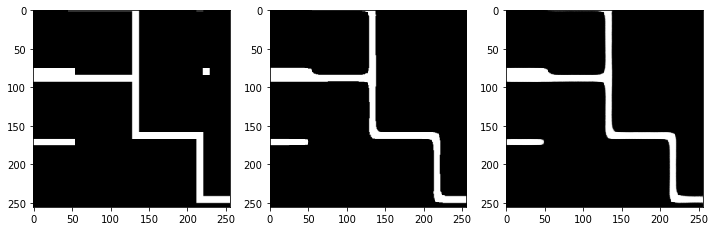

Epoch [47 / 100] time: 538.78 (sec) average reconstruction error: 247525.181343
Epoch [48 / 100] time: 534.45 (sec) average reconstruction error: 246982.232554
Epoch [49 / 100] time: 526.01 (sec) average reconstruction error: 247993.561308
Epoch [50 / 100] time: 531.64 (sec) average reconstruction error: 246578.879370
Epoch [51 / 100] time: 528.18 (sec) average reconstruction error: 246689.163996
Validation error: 271135.094602


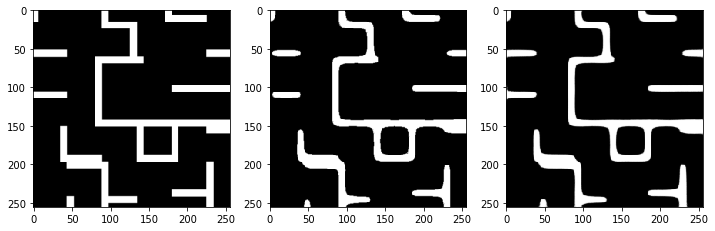

Epoch [52 / 100] time: 529.13 (sec) average reconstruction error: 245447.025920
Epoch [53 / 100] time: 534.08 (sec) average reconstruction error: 246301.764301
Epoch [54 / 100] time: 529.91 (sec) average reconstruction error: 246149.878277
Epoch [55 / 100] time: 530.17 (sec) average reconstruction error: 245617.684256
Epoch [56 / 100] time: 526.13 (sec) average reconstruction error: 246951.234176
Validation error: 276217.863920


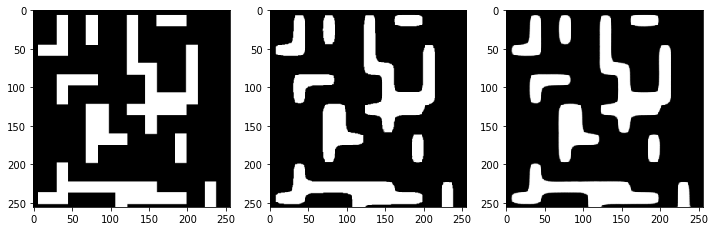

Epoch [57 / 100] time: 528.53 (sec) average reconstruction error: 245666.004568
Epoch [58 / 100] time: 537.07 (sec) average reconstruction error: 244980.826238
Epoch [59 / 100] time: 530.39 (sec) average reconstruction error: 246442.514963
Epoch [60 / 100] time: 533.93 (sec) average reconstruction error: 244512.432104
Epoch [61 / 100] time: 528.25 (sec) average reconstruction error: 244341.154595
Validation error: 274577.567614


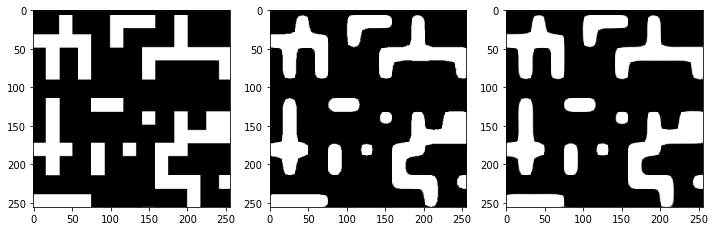

Epoch [62 / 100] time: 534.17 (sec) average reconstruction error: 244096.943293
Epoch [63 / 100] time: 531.37 (sec) average reconstruction error: 243536.808726
Epoch [64 / 100] time: 529.04 (sec) average reconstruction error: 243909.370630
Epoch [65 / 100] time: 527.98 (sec) average reconstruction error: 243511.914592
Epoch [66 / 100] time: 529.03 (sec) average reconstruction error: 241965.403403
Validation error: 273200.406818


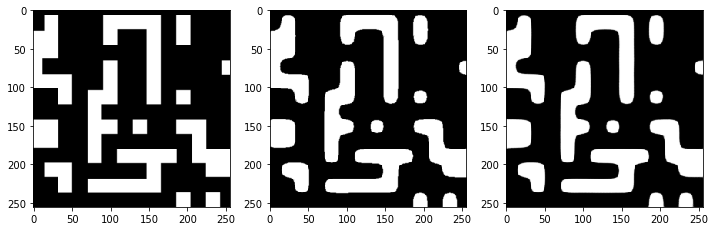

Epoch [67 / 100] time: 528.96 (sec) average reconstruction error: 242664.427734
Epoch [68 / 100] time: 530.62 (sec) average reconstruction error: 243143.169359
Epoch [69 / 100] time: 529.41 (sec) average reconstruction error: 242070.671809
Epoch [70 / 100] time: 528.73 (sec) average reconstruction error: 241879.999934
Epoch [71 / 100] time: 527.64 (sec) average reconstruction error: 241836.081535
Validation error: 275531.521591


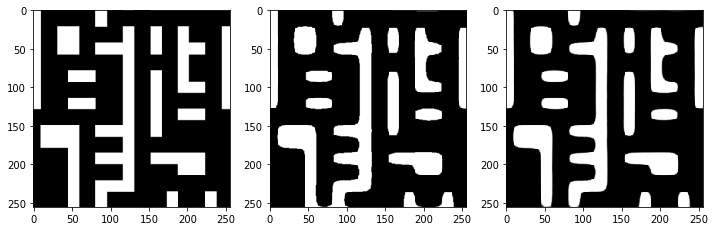

Epoch [72 / 100] time: 532.29 (sec) average reconstruction error: 241533.182899
Epoch [73 / 100] time: 530.90 (sec) average reconstruction error: 241859.007051
Epoch [74 / 100] time: 529.48 (sec) average reconstruction error: 241261.182137
Epoch [75 / 100] time: 531.29 (sec) average reconstruction error: 241142.268770
Epoch [76 / 100] time: 539.03 (sec) average reconstruction error: 240612.358216
Validation error: 275018.031818


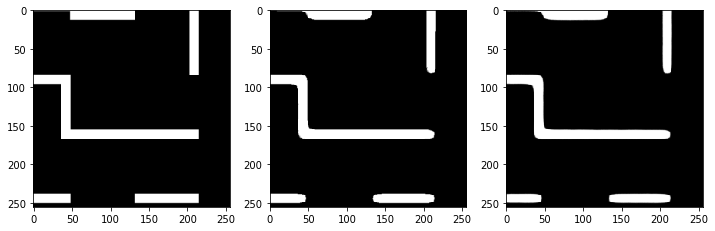

Epoch [77 / 100] time: 532.08 (sec) average reconstruction error: 240773.666545
Epoch [78 / 100] time: 532.22 (sec) average reconstruction error: 241202.843882
Epoch [79 / 100] time: 532.64 (sec) average reconstruction error: 240811.379767
Epoch [80 / 100] time: 531.24 (sec) average reconstruction error: 240381.170915
Epoch [81 / 100] time: 528.55 (sec) average reconstruction error: 240136.016817
Validation error: 278022.291477


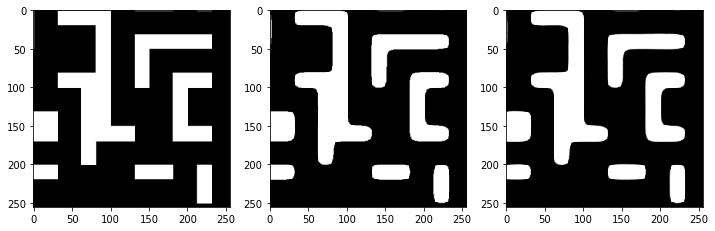

Epoch [82 / 100] time: 526.83 (sec) average reconstruction error: 239694.333024
Epoch [83 / 100] time: 528.89 (sec) average reconstruction error: 240707.713222
Epoch [84 / 100] time: 529.72 (sec) average reconstruction error: 239218.947630
Epoch [85 / 100] time: 529.07 (sec) average reconstruction error: 240136.641353
Epoch [86 / 100] time: 535.67 (sec) average reconstruction error: 239188.228151
Validation error: 280130.548011


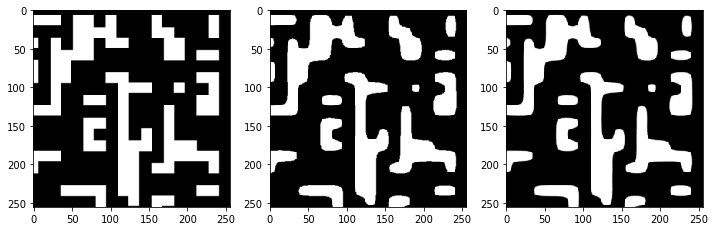

Epoch [87 / 100] time: 524.90 (sec) average reconstruction error: 238440.636818
Epoch [88 / 100] time: 526.09 (sec) average reconstruction error: 239012.041181
Epoch [89 / 100] time: 528.04 (sec) average reconstruction error: 238936.480369
Epoch [90 / 100] time: 534.66 (sec) average reconstruction error: 238929.015625
Epoch [91 / 100] time: 531.41 (sec) average reconstruction error: 238409.910984
Validation error: 278366.679261


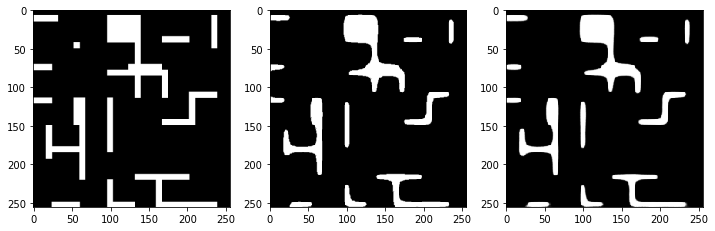

Epoch [92 / 100] time: 531.63 (sec) average reconstruction error: 237987.163202
Epoch [93 / 100] time: 534.87 (sec) average reconstruction error: 237729.124868
Epoch [94 / 100] time: 527.32 (sec) average reconstruction error: 238104.576238
Epoch [95 / 100] time: 530.08 (sec) average reconstruction error: 237909.589049
Epoch [96 / 100] time: 532.02 (sec) average reconstruction error: 238375.075212
Validation error: 279580.662784


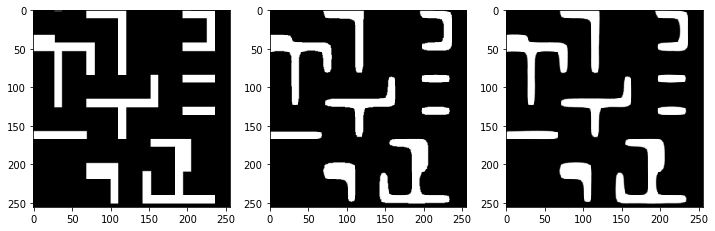

Epoch [97 / 100] time: 527.02 (sec) average reconstruction error: 238793.116062
Epoch [98 / 100] time: 529.69 (sec) average reconstruction error: 239148.342293
Epoch [99 / 100] time: 533.75 (sec) average reconstruction error: 237605.618015
Epoch [100 / 100] time: 529.74 (sec) average reconstruction error: 238011.136785


In [21]:
optimizer = torch.optim.Adam(params=unet.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
unet.train()

train_loss_avg = []
test_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    start_time = time.time()

    for image_batch, out_image_batch in train_dataloader:
        
        image_batch = image_batch.to(device)
        out_image_batch = out_image_batch.to(device)

        # unet reconstruction
        recon_image_batch = unet(image_batch)
        
        # reconstruction error
        loss = F.binary_cross_entropy(recon_image_batch.view(-1, image_size**2), 
                                        out_image_batch.view(-1, image_size**2), reduction='sum')

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
          
    train_loss_avg[-1] /= num_batches
    end_time = time.time()
    print('Epoch [%d / %d] time: %.2f (sec) average reconstruction error: %f' % (epoch+1, num_epochs, end_time-start_time, train_loss_avg[-1]))
      
    if epoch % 5 == 0:
        test_loss = []
        for image_batch, out_image_batch in test_dataloader:
            image_batch = image_batch.to(device)
            out_image_batch = out_image_batch.to(device)
            recon_image_batch = unet(image_batch)
            loss = F.binary_cross_entropy(recon_image_batch.view(-1, image_size**2), 
                                          out_image_batch.view(-1, image_size**2), reduction='sum')
            test_loss.append(loss.item())
        
        test_loss_avg.append(np.mean(test_loss))
        print('Validation error: %f' % (test_loss_avg[-1]))
        
        fig, ax = plt.subplots(1,3, figsize=(12,5))
        ax[0].imshow(image_batch[0].cpu().detach().squeeze(), cmap='gray')
        ax[1].imshow(out_image_batch[0].cpu().detach().squeeze(), cmap='gray')
        ax[2].imshow(recon_image_batch[0].cpu().detach().squeeze(), cmap='gray')
        plt.show()
        
        if not os.path.isdir('./Unet_checkpoints'):
            os.makedirs('./Unet_checkpoints')
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': unet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss_avg,
                    'val_loss': test_loss_avg
                    }, './Unet_checkpoints/Unet_epoch_{}.pth'.format(epoch))

#         model = TheModelClass(*args, **kwargs)
#         optimizer = TheOptimizerClass(*args, **kwargs)

#         checkpoint = torch.load(PATH)
#         model.load_state_dict(checkpoint['model_state_dict'])
#         optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#         epoch = checkpoint['epoch']
#         loss = checkpoint['loss']

#         model.eval()
#         # - or -
#         model.train()

Plot Training Curve
--------------------

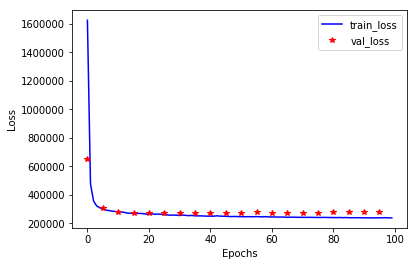

In [22]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg, 'b', label='train_loss')
plt.plot(range(0,100,5), test_loss_avg, 'r*', label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Alternatively: Load Pre-Trained VAE
-----------------------------

In [0]:
filename = 'vae_2d.pth'
# filename = 'vae_10d.pth'
import urllib
if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve ("http://geometry.cs.ucl.ac.uk/creativeai/pretrained/"+filename, "./pretrained/"+filename)
vae.load_state_dict(torch.load('./pretrained/'+filename))
print('done')

# this is how the VAE parameters can be saved:
# torch.save(vae.state_dict(), './pretrained/my_vae.pth')

Evaluate on the Test Set
-------------------------

In [0]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 19294.807126


Visualize Reconstructions
--------------------------

Original images


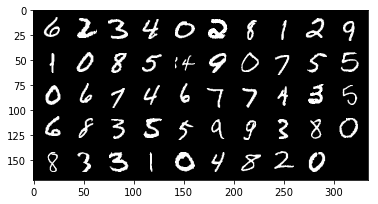

VAE reconstruction:


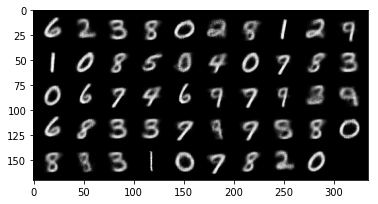

In [0]:
import numpy as np
import matplotlib.pyplot as plt
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
print('Original images')
show_image(torchvision.utils.make_grid(images[1:50],10,5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)

Interpolate in Latent Space
----------------------------

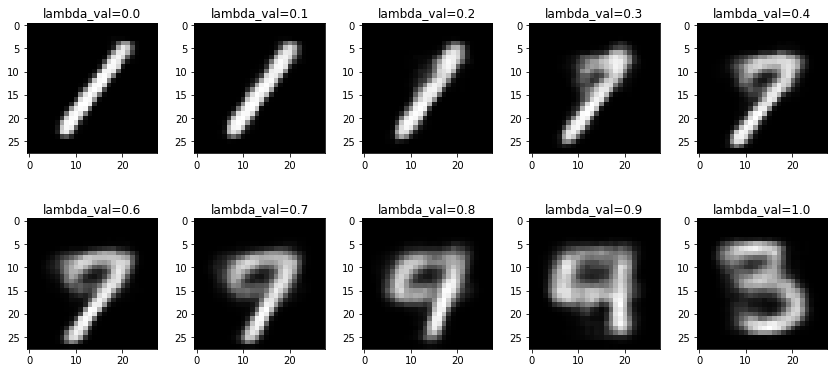

In [0]:
vae.eval()

def interpolation(lambda1, model, img1, img2):
    
    with torch.no_grad():
    
        # latent vector of first image
        img1 = img1.to(device)
        latent_1, _ = model.encoder(img1)

        # latent vector of second image
        img2 = img2.to(device)
        latent_2, _ = model.encoder(img2)

        # interpolation of the two latent vectors
        inter_latent = lambda1* latent_1 + (1- lambda1) * latent_2

        # reconstruct interpolated image
        inter_image = model.decoder(inter_latent)
        inter_image = inter_image.cpu()

        return inter_image
    
# sort part of test set by digit
digits = [[] for _ in range(10)]
for img_batch, label_batch in test_dataloader:
    for i in range(img_batch.size(0)):
        digits[label_batch[i]].append(img_batch[i:i+1])
    if sum(len(d) for d in digits) >= 1000:
        break;

# interpolation lambdas
lambda_range=np.linspace(0,1,10)

fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for ind,l in enumerate(lambda_range):
    inter_image=interpolation(float(l), vae, digits[7][0], digits[1][0])
   
    inter_image = to_img(inter_image)
    
    image = inter_image.numpy()
   
    axs[ind].imshow(image[0,0,:,:], cmap='gray')
    axs[ind].set_title('lambda_val='+str(round(l,1)))
plt.show() 

Sample Latent Vector from Prior (VAE as Generator)
-------------------------------------------------

A VAE can generate new digits by drawing latent vectors from the prior distribution. Although the generated digits are not perfect, they are usually better than for a non-variational Autoencoder (compare results for the 10d VAE to the results for the autoencoder).

Similar to autoencoders, the manifold of latent vectors that decode to valid digits is sparser in higher-dimensional latent spaces. Increasing the weight of the KL-divergence term in the loss (increasing `variational_beta`) makes the manifold less sparse at the cost of a lower-quality reconstruction. A pre-trained model with `variational_beta = 10` is available at `./pretrained/vae_10d_beta10.pth`.

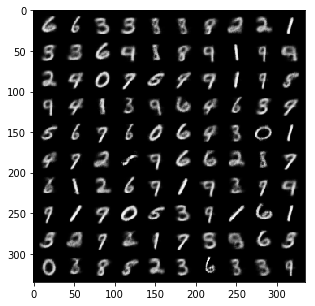

In [0]:
vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, latent_dims, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(5, 5))
    show_image(torchvision.utils.make_grid(img_recon.data[:100],10,5))
    plt.show()

Show 2D Latent Space
---------------------

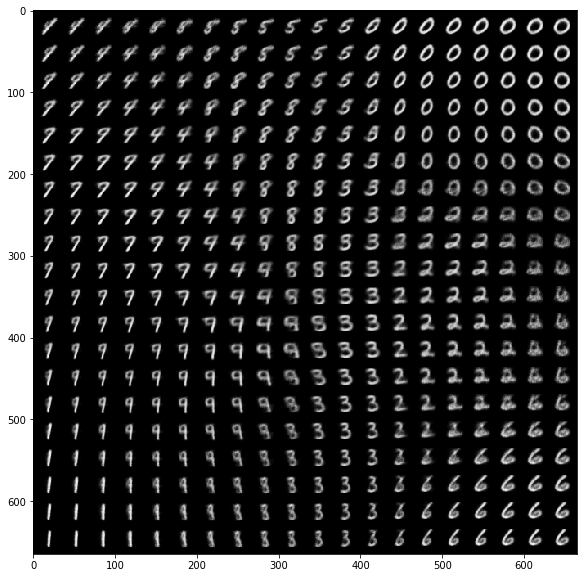

In [0]:
# load a network that was trained with a 2d latent space
if latent_dims != 2:
    print('Please change the parameters to two latent dimensions.')
    
with torch.no_grad():
    
    # create a sample grid in 2d latent space
    latent_x = np.linspace(-1.5,1.5,20)
    latent_y = np.linspace(-1.5,1.5,20)
    latents = torch.FloatTensor(len(latent_y), len(latent_x), 2)
    for i, lx in enumerate(latent_x):
        for j, ly in enumerate(latent_y):
            latents[j, i, 0] = lx
            latents[j, i, 1] = ly
    latents = latents.view(-1, 2) # flatten grid into a batch

    # reconstruct images from the latent vectors
    latents = latents.to(device)
    image_recon = vae.decoder(latents)
    image_recon = image_recon.cpu()

    fig, ax = plt.subplots(figsize=(10, 10))
    show_image(torchvision.utils.make_grid(image_recon.data[:400],20,5))
    plt.show()